# Calculating Raman intensities

PyNAO can be used with the ASE `vibrations` module to calculate both static and
resonant intensities of the Raman vibration modes. It uses the Placzek approximation
implemented in ASE by Prof. M. Walter. When using this module for your work,
please cite

*M. Walter and M. Moseler, Ab Initio Wavelength-Dependent Raman Spectra:
Placzek Approximation and Beyond, J. Chem. Theory Comput. 2020, 16, 1, 576–586*


In this example, we will calculate the Raman intensities of a CO2 molecule

## Calculating the static Raman intensities

In [2]:
import numpy as np
from ase import Atoms
from ase.calculators.siesta import Siesta
from ase.calculators.siesta.siesta_lrtddft import RamanCalculatorInterface
from ase.vibrations.raman import StaticRamanCalculator
from ase.vibrations.placzek import PlaczekStatic
from ase.units import Ry, eV, Ha


CO2 = Atoms('CO2',
            positions=[[-0.009026, -0.020241, 0.026760],
                       [1.167544, 0.012723, 0.071808],
                       [-1.185592, -0.053316, -0.017945]],
            cell=[20, 20, 20])

# set-up the Siesta parameters
CO2.calc = Siesta(
      mesh_cutoff=250 * Ry,
      basis_set='DZP',
      pseudo_qualifier='gga',
      xc="PBE",
      energy_shift=(25 * 10**-3) * eV,
      fdf_arguments={
        'SCFMustConverge': False,
        'COOP.Write': True,
        'WriteDenchar': True,
        'PAO.BasisType': 'split',
        'DM.Tolerance': 1e-4,
        'DM.MixingWeight': 0.01,
        "MD.NumCGsteps": 0,
        "MD.MaxForceTol": (0.02, "eV/Ang"),
        'MaxSCFIterations': 10000,
        'DM.NumberPulay': 4,
        'XML.Write': True,
        "WriteCoorXmol": True,
        "DM.UseSaveDM": True,})

name = 'co2'
rm = StaticRamanCalculator(CO2, RamanCalculatorInterface, name=name, delta=0.011,
                           exkwargs=dict(label="siesta", jcutoff=7, iter_broadening=0.15,
                                         xc_code='LDA,PZ', tol_loc=1e-6, tol_biloc=1e-7,
                                         krylov_options={"tol": 1.0e-5, "atol": 1.0e-5}))

# save dipole moments from DFT calculation in order to get
# infrared intensities as well
rm.ir = True
rm.run()

pz = PlaczekStatic(CO2, name=name)
e_vib = pz.get_energies()
pz.summary()

Writing co2.eq.pckl, dipole moment = (-0.000052 0.000020 -0.000097)
Total number of iterations:  30
Writing co2.0x-.pckl, dipole moment = (-0.022999 -0.000500 -0.000805)
Total number of iterations:  30
Writing co2.0x+.pckl, dipole moment = (0.022946 0.000541 0.000611)
Total number of iterations:  30
Writing co2.0y-.pckl, dipole moment = (-0.000533 -0.004412 -0.000116)
Total number of iterations:  30
Writing co2.0y+.pckl, dipole moment = (0.000488 0.004502 -0.000077)
Total number of iterations:  30
Writing co2.0z-.pckl, dipole moment = (-0.000745 -0.000018 -0.004569)
Total number of iterations:  30
Writing co2.0z+.pckl, dipole moment = (0.000678 0.000041 0.004399)
Total number of iterations:  30
Writing co2.1x-.pckl, dipole moment = (0.011596 0.000281 0.000263)
Total number of iterations:  30
Writing co2.1x+.pckl, dipole moment = (-0.011393 -0.000232 -0.000437)
Total number of iterations:  30
Writing co2.1y-.pckl, dipole moment = (0.000231 0.002235 -0.000086)
Total number of iterations:

In [5]:
from ase.vibrations.infrared import InfraRed
# finite displacement for vibrations
ir = InfraRed(CO2, name=name)
ir.run()
ir.summary()

-------------------------------------
 Mode    Frequency        Intensity
  #    meV     cm^-1   (D/Å)^2 amu^-1
-------------------------------------
  0   34.2i    275.6i     0.0026
  1   29.7i    239.4i     0.0014
  2   17.1     137.6      0.0001
  3   20.7     166.9      0.0004
  4   35.2     284.1      0.0071
  5   76.7     618.4      0.5261
  6   78.0     628.9      0.5142
  7  173.3    1397.4      0.0008
  8  309.9    2499.5     13.9984
-------------------------------------
Zero-point energy: 0.355 eV
Static dipole moment: 0.001 D
Maximum force on atom in `equilibrium`: 1.0566 eV/Å



## Summary

Let's summarized our results for Infra-red and Raman intensities in a clear table.

| Quantity | Method    | 1 bending | 2 stretching | 3 asymmetric streching |
| :------: | :-------: | :-------: | :----------: | :--------------------: |
| $\omega$ (cm$^{-1}$) | exp<br> ASE <br> QE| 667.00<br> 623.65 <br> 608.45 | 1330.00 <br> 1397.40 <br> 1271.13 | 2349.00 <br> 2499.50 <br> 2223.67 |
| IR $(D/A)^{2}$ amu$^{-1}$| ASE <br> QE | 0.52 <br> 0.45 | 0.00 <br> 0.02 | 14.00 <br> 12.33 |
| Raman ($A^{4}$ amu$^{-1}$) | ASE <br> QE | 0.02<br>0.00 | 21.21 <br> 23.82 | 0.00 <br> 0.00 |

The intensities we calculated are given by the ASE rows, experimental values are
given for the infra-red intensities values as well as Quantum Expresso calculations.
More details can be found in Chapter 7 of M. Barbry PhD thesis.

## Resonant Raman calculations

As explained in M. Walter paper, the Placzek is good enough to get the resonant
Raman intensities, for this one can pass the parameter `omega` to the `RamanCalculatorInterface`
object.

But first lets find the frequency we want to calculate for. In order to do this,
we will calculate the polarizability of the CO2 molecule.

In [6]:
from ase.calculators.siesta.siesta_lrtddft import SiestaLRTDDFT

LRTDDFT = SiestaLRTDDFT(label="siesta", jcutoff=7, iter_broadening=0.15,
                        xc_code='LDA,PZ', tol_loc=1e-6, tol_biloc=1e-7,
                        krylov_options={"tol": 1.0e-5, "atol": 1.0e-5})

# run siesta
LRTDDFT.get_ground_state(CO2, mesh_cutoff=250 * Ry,
                         basis_set='DZP',
                         pseudo_qualifier='gga',
                         xc="PBE",
                         energy_shift=(25 * 10**-3) * eV,
                         fdf_arguments={
                            'SCFMustConverge': False,
                            'COOP.Write': True,
                            'WriteDenchar': True,
                            'PAO.BasisType': 'split',
                            'DM.Tolerance': 1e-4,
                            'DM.MixingWeight': 0.01,
                            "MD.NumCGsteps": 0,
                            "MD.MaxForceTol": (0.02, "eV/Ang"),
                            'MaxSCFIterations': 10000,
                            'DM.NumberPulay': 4,
                            'XML.Write': True,
                            "WriteCoorXmol": True,
                            "DM.UseSaveDM": True,})

# Get polarizability
freq = np.arange(0.0, 25.0, 0.5)
pmat = LRTDDFT.get_polarizability(freq)

Total number of iterations:  1756


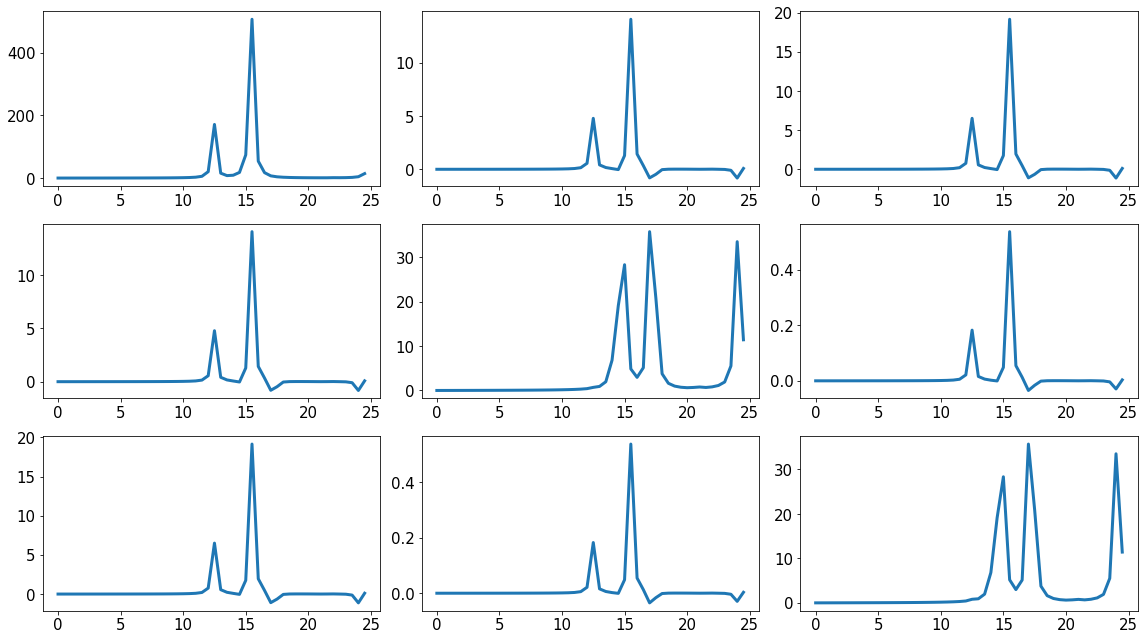

In [7]:
import matplotlib.pyplot as plt

h = 9
w = 16*h/9
fig = plt.figure(1, figsize=(w, h))

iax = 1
for i in range(3):
    for j in range(3):
        ax = fig.add_subplot(3, 3, iax)
        
        ax.plot(freq, pmat[i, j, :].imag, linewidth=3)
        iax += 1
        
fig.tight_layout()
plt.show()

Let's focus on the excitation around 15 eV

In [8]:
# Get polarizability
freq = np.arange(14.0, 16.0, 0.01)
pmat2 = LRTDDFT.get_polarizability(freq)

Total number of iterations:  8596


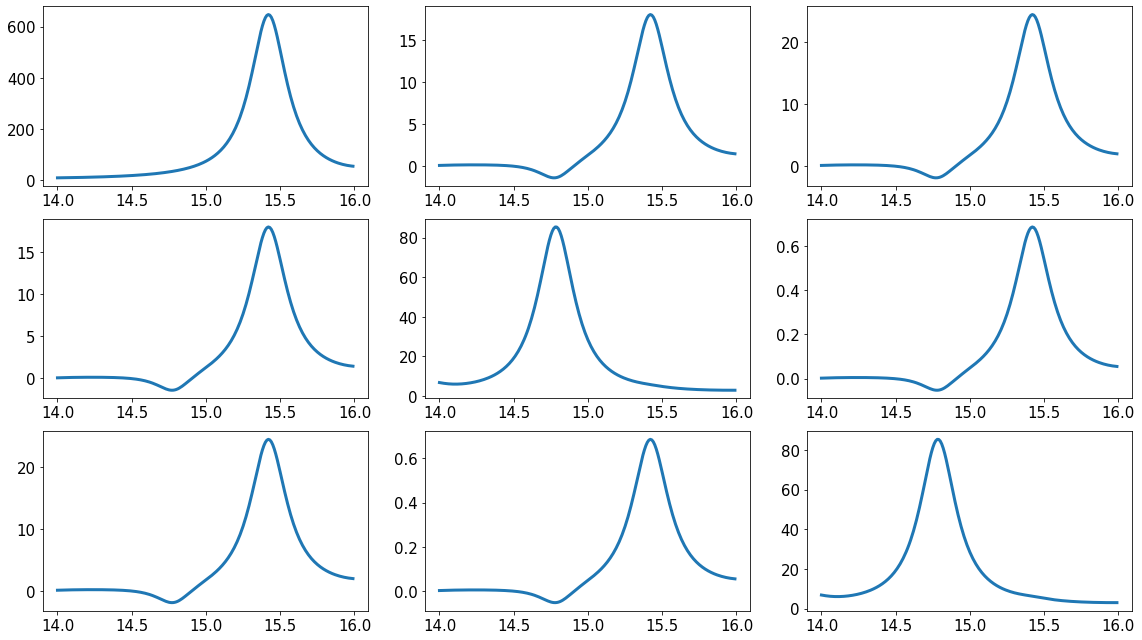

In [9]:
import matplotlib.pyplot as plt

h = 9
w = 16*h/9
fig = plt.figure(1, figsize=(w, h))

iax = 1
for i in range(3):
    for j in range(3):
        ax = fig.add_subplot(3, 3, iax)
        
        ax.plot(freq, pmat2[i, j, :].imag, linewidth=3)
        iax += 1
        
fig.tight_layout()
plt.show()

In [10]:
freq_max_int = freq[np.argmax(pmat2[2, 2, :])]
print("excitation frequency along zz is ", freq_max_int)

excitation frequency along zz is  14.639999999999986


In [11]:
name = 'co2-res'
rm = StaticRamanCalculator(CO2, RamanCalculatorInterface, name=name, delta=0.011,
                           exkwargs=dict(omega=freq_max_int, label="siesta", jcutoff=7, iter_broadening=0.15,
                                         xc_code='LDA,PZ', tol_loc=1e-6, tol_biloc=1e-7,
                                         krylov_options={"tol": 1.0e-5, "atol": 1.0e-5}, verbose=5))

# save dipole moments from DFT calculation in order to get
# infrared intensities as well
rm.ir = True
rm.run()

pz = PlaczekStatic(CO2, name=name)
e_vib = pz.get_energies()
pz.summary()

Writing co2-res.eq.pckl, dipole moment = (-0.000026 0.000020 -0.000117)
Total number of iterations:  45
Writing co2-res.0x-.pckl, dipole moment = (-0.023009 -0.000500 -0.000805)
Total number of iterations:  46
Writing co2-res.0x+.pckl, dipole moment = (0.022946 0.000541 0.000611)
Total number of iterations:  46
Writing co2-res.0y-.pckl, dipole moment = (-0.000533 -0.004412 -0.000116)
Total number of iterations:  49
Writing co2-res.0y+.pckl, dipole moment = (0.000488 0.004502 -0.000077)
Total number of iterations:  49
Writing co2-res.0z-.pckl, dipole moment = (-0.000745 -0.000018 -0.004569)
Total number of iterations:  49
Writing co2-res.0z+.pckl, dipole moment = (0.000678 0.000041 0.004399)
Total number of iterations:  49
Writing co2-res.1x-.pckl, dipole moment = (0.011596 0.000281 0.000263)
Total number of iterations:  47
Writing co2-res.1x+.pckl, dipole moment = (-0.011393 -0.000232 -0.000437)
Total number of iterations:  46
Writing co2-res.1y-.pckl, dipole moment = (0.000231 0.00223

In [14]:
res = 100*318.36
static = 0.1*212.10
print(static, res, res/static)

21.21 31836.0 1500.9900990099009


## Raman intensities enhancement

Let's analyse the enhancement of the resonant Raman intensity compared to the
static one for the mode at $\omega = 1397.4$ cm$^{-1}$. The intensities are
(taking into account the scaling factor in the summary)

* static: $I_{sta} = 21.21$ A$^{4}$/amu
* resonant: $I_{res} = 31836.0$ A$^{4}$/amu

Leading to an enhancement of around 1500